<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Обзор-данных-и-их-подготовка" data-toc-modified-id="Обзор-данных-и-их-подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных и их подготовка</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение-моделей-и-подготовка-к-нему" data-toc-modified-id="Обучение-моделей-и-подготовка-к-нему-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей и подготовка к нему</a></span><ul class="toc-item"><li><span><a href="#Создание-дополнительных-признаков" data-toc-modified-id="Создание-дополнительных-признаков-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Создание дополнительных признаков</a></span></li><li><span><a href="#Создание-выборок" data-toc-modified-id="Создание-выборок-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Создание выборок</a></span></li><li><span><a href="#Подготовка-и-обучение-моделей" data-toc-modified-id="Подготовка-и-обучение-моделей-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Подготовка и обучение моделей</a></span></li></ul></li><li><span><a href="#Тестирование-выбранной-модели" data-toc-modified-id="Тестирование-выбранной-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование выбранной модели</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

# Проект: "Прогнозирование заказов такси"

## Описание проекта

Служба такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо модель для такого предсказания.  
Значение целевой метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:  
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Обзор данных и их подготовка 

In [1]:
# проверка наличия библиотек
try:
    import lightgbm as lgbm
    print('LightGBM ver.:', lgbm.__version__)
except:
    !pip install lightgbm
    
try:
    import optuna
    print('Optuna ver.:', optuna.__version__)
except:
    !pip install optuna

LightGBM ver.: 3.3.5
Optuna ver.: 3.1.0


In [60]:
# импорт библиотек
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from lightgbm import LGBMRegressor

from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, FloatDistribution, IntDistribution

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# # подавление вывода при оптимизации
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import warnings
warnings.simplefilter('ignore')

In [3]:
# чтение файла данных из папки по умолчанию и из рабочей директории с парсингом дат
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0], infer_datetime_format=True, cache_dates=True)
except:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0], infer_datetime_format=True, cache_dates=True)

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# общая информация
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Оценим наличие пропусков в датах и их хронологическую последовательность.

In [5]:
# проверка монотонности
if data.index.is_monotonic_increasing:
    print('Данные хронологически упорядочены.')
else:
    print('Данные хронологически не упорядочены!')

Данные хронологически упорядочены.


In [6]:
# общее число десятиминутных отрезков
n_10frame = ((data.index.max() - data.index.min())).total_seconds() / (10 * 60) + 1
# число уникальных значений в датах
n_time_uniques = pd.Series(data.index).astype('category').describe(datetime_is_numeric=False)['unique']
# проверка пропусков
if n_10frame == n_time_uniques == len(data):
    print('Пропуски в датах отсутствуют.')
else:
    print('Имеются пропуски в датах!')

Пропуски в датах отсутствуют.


In [7]:
# разница между первой и последней датами
print('Дата начала наблюдений: {}'.format(data.index.min()))
print('Дата окончания наблюдений: {}'.format(data.index.max()))
print('Временной отрезок: {}'.format(data.index.max() - data.index.min()))

Дата начала наблюдений: 2018-03-01 00:00:00
Дата окончания наблюдений: 2018-08-31 23:50:00
Временной отрезок: 183 days 23:50:00


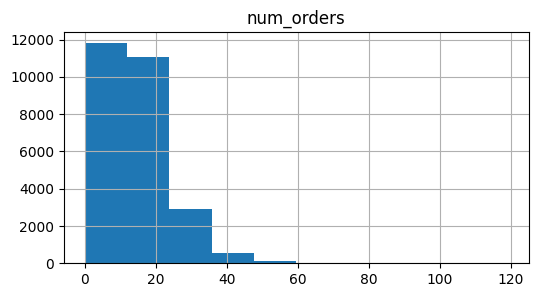

In [8]:
data.hist(figsize=(6,3));

In [9]:
# агрегация данных в часовой таймфрейм
data = data.resample(rule='1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Исходные данные содержат информацию о количестве заказов такси с марта по август 2018 года. Они не имеют пропусков и хронологически упорядочены. Данные приводятся для десятиминутного интервала и варьируются по большей части в диапазоне от 8 до 19 заказов.  
Для упрощения анализа данные были ресемплированы для часового интервала.

## Анализ данных

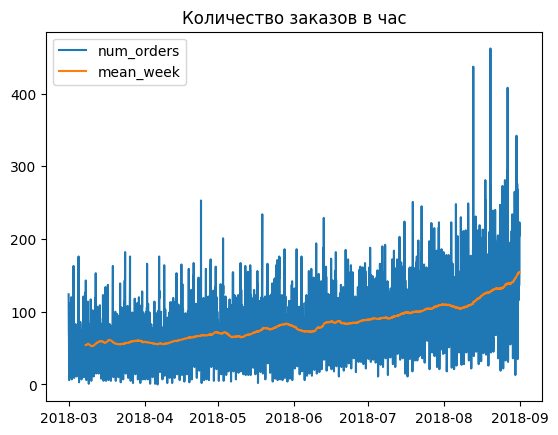

In [10]:
# график числа заказов в час и в среднем за неделю
plt.plot(data, label='num_orders')
plt.plot(data.rolling(24*7).mean(), label='mean_week')
plt.title('Количество заказов в час')
plt.legend()
plt.show;

Наличие ярко выраженного тренда не позволяет отнести наш временной ряд к стационарным. О нестационарном характере ряда говорит и рост отклонений от среднего в течении последних двух месяцев.  
Оценим наличие цикличности в графике заказов. Наиболее естественным предположением является её наличие в недельных и суточных изменениях. Оценить годовую сезонность невозможно из-за недостаточного числа данных.

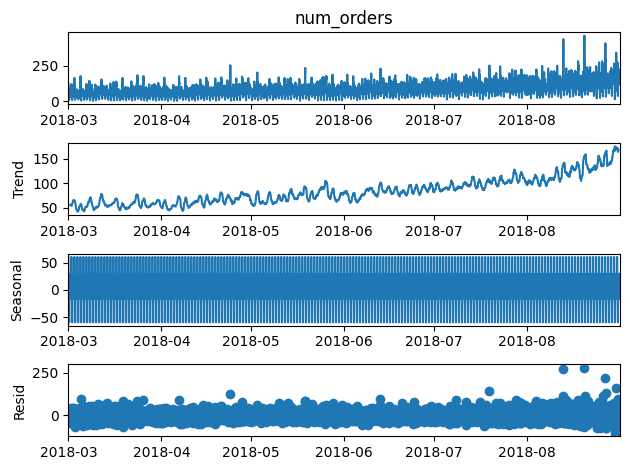

In [11]:
seasonal_decompose(data['num_orders']).plot();

На графики декомпозиции временного ряда видно наличие уже замеченного нами ранее тренда, который в последний месяц стал более выраженным. Сильная сезонность понемногу снижается со временем. В последний месяц вырос разброс остатков декомпозиции.  
Чтобы проверить наши предположения о цикличности уменьшим масштаб графика.

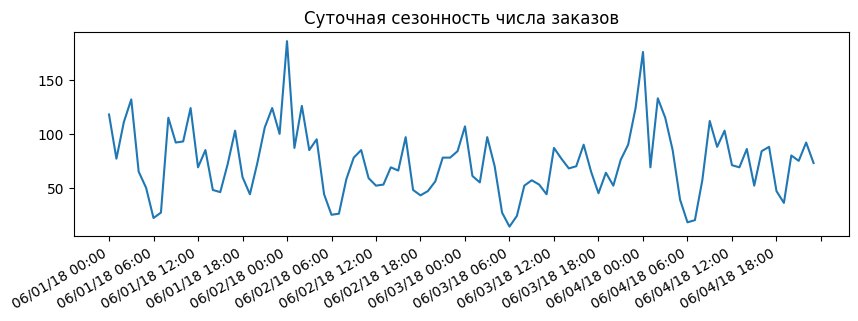

In [12]:
# график дневной сезонности числа заказов 
data_days = data['2018-06-01':'2018-06-04']
data_days_seasonal = seasonal_decompose(data_days).seasonal

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(data_days.index.strftime('%x %H:00'), data_days)
plt.title('Суточная сезонность числа заказов')
ax.set_xticks(np.arange(0, len(data_days)+1, 6))
fig.autofmt_xdate();

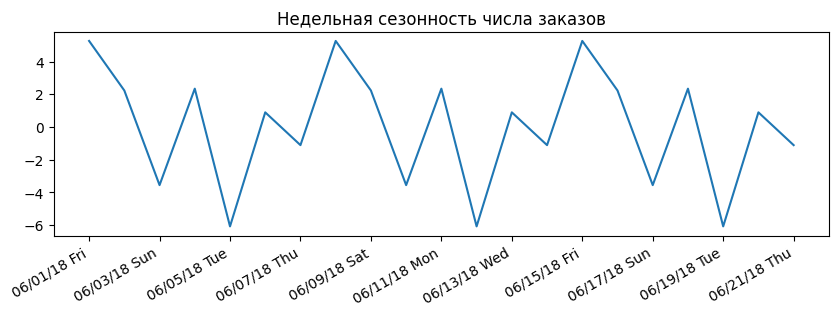

In [13]:
# график недельной сезонности числа заказов 
data_weeks = data['2018-06-01':'2018-06-21'].resample(rule='1D').mean()
data_weeks_seasonal = seasonal_decompose(data_weeks).seasonal

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(data_weeks.index.strftime('%x %a'), data_weeks_seasonal)
plt.title('Недельная сезонность числа заказов')
ax.set_xticks(np.arange(0, len(data_weeks)+1, 2))
fig.autofmt_xdate();

Декомпозиция временного ряда подтвердила цикличность изменения числа заказов от времени суток дня недели. По времени суток спад наблюдается ранним утром, пик - перед полуночью. По дням недели наибольший спад наблюдается во вторник, пик - в пятницу.

## Обучение моделей и подготовка к нему

### Создание дополнительных признаков

Для увеличения числа зависимостей в данных обогатим признаковое пространство дополнительными признаками. А, именно, добавим признаки с временными лагами, с использованием скользящих окон, указатели времени суток и дня недели. Дополнительно добавим разность временного ряда.

In [14]:
# функция создания признаков для таймсерий
def generate_features(data_original, n_lags, n_ma, n_difFs, *args):
    data_expanded = data_original.copy()
    # признаки сезонности
    if 'hour' in args:
        data_expanded['hour'] = data_expanded.index.hour
    if 'weekday' in args:
        data_expanded['weekday'] = data_expanded.index.weekday
    if 'month' in args:
        data_expanded['month'] = data_expanded.index.month
    # признаки временных лагов
    for i in range(1, n_lags+1, 1):
        data_expanded['lag%s' %i] = data_expanded['num_orders'].shift(i)
    # признаки скользящих окон
    for i in range(1, n_ma+1, 1):
        data_expanded['ma%s' %i] = data_expanded['num_orders'].rolling(i, closed='left').mean()
    # признаки разностей временного ряда
    for i in range(1, n_difFs+1, 1):
        data_expanded['diff%s' %i] = data_expanded['num_orders'].shift().diff(periods=i)
    return data_expanded

In [15]:
# создание признаков
df = generate_features(data, 12, 12, 6, *['hour', 'weekday'])
    
# изменение типов признаков
df['num_orders'] = df['num_orders'].astype('float64')
df.dropna(inplace=True)
df.head()

,num_orders,hour,weekday,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,ma9,ma10,ma11,ma12,diff1,diff2,diff3,diff4,diff5,diff6
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 12:00:00,30.0,12,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,...,45.000000,47.6,51.000000,57.083333,32.0,27.0,62.0,81.0,84.0,90.0
2018-03-01 13:00:00,32.0,13,3,30.0,96.0,64.0,69.0,34.0,15.0,12.0,...,41.000000,43.5,46.000000,49.250000,-66.0,-34.0,-39.0,-4.0,15.0,18.0
2018-03-01 14:00:00,48.0,14,3,32.0,30.0,96.0,64.0,69.0,34.0,15.0,...,39.777778,40.1,42.454545,44.833333,2.0,-64.0,-32.0,-37.0,-2.0,17.0
2018-03-01 15:00:00,66.0,15,3,48.0,32.0,30.0,96.0,64.0,69.0,34.0,...,44.444444,40.6,40.818182,42.916667,16.0,18.0,-48.0,-16.0,-21.0,14.0
2018-03-01 16:00:00,43.0,16,3,66.0,48.0,32.0,30.0,96.0,64.0,69.0,...,50.444444,46.6,42.909091,42.916667,18.0,34.0,36.0,-30.0,2.0,-3.0


### Создание выборок

In [16]:
# создание выборок
features_train, features_test, target_train, target_test = train_test_split(
    df.drop('num_orders', axis=1), df['num_orders'], test_size=0.1, random_state=42, shuffle=False
)

In [17]:
# число сплитов на основе размеров выборок
n_splits_calc = (len(target_train) // len(target_test)) - 1
# сплиттер таймсерий для оптимизатора
splitter = TimeSeriesSplit(n_splits=n_splits_calc)

### Подготовка и обучение моделей

In [18]:
# выделение действительных признаков
num_cols = features_train.select_dtypes(include=['float64']).columns.tolist()
# признаки, которые можно отнести к категориальным
cat_cols = features_train.select_dtypes(exclude=['float64']).columns.tolist()

# раздельное кодирование признаков и последующим объединением в плотную матрицу
preprocessor = ColumnTransformer([
    ('num_coder', StandardScaler(), num_cols),
    ('cat_coder', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_cols)]
)

In [61]:
# список моделей с параметрами для optuna
models = [
    ('LGBMRegressor', LGBMRegressor(random_state=42, verbose_eval=False), {
        'reg__learning_rate': FloatDistribution(0.1, 0.5, 0.05),
        'reg__n_estimators': IntDistribution(100, 300, 30),
        'reg__max_depth': IntDistribution(6, 20, 2)}),
    ('LinearRegression', LinearRegression(), {}),
    ('ElasticNet', ElasticNet(max_iter=4000, random_state=42), {
        'reg__alpha': FloatDistribution(0.1, 1, 0.1),
        'reg__l1_ratio': FloatDistribution(0.1, 1, 0.1)}),
    ('KNeighborsRegressor', KNeighborsRegressor(), {
        'reg__n_neighbors': IntDistribution(2, 10, 1),}),
    ('DummyRegressor', DummyRegressor(), {
        'reg__strategy': CategoricalDistribution(['mean', 'median', 'quantile']),
        'reg__quantile': FloatDistribution(0.1, 1, 0.1)})
]

In [63]:
# список результатов и обученных моделей
results = []
# проход по списку моделей
for name, model, param in models:
    search_cv = OptunaSearchCV(estimator=Pipeline(steps=[('prep', preprocessor), ('reg', model)]),
                               param_distributions=param,
                               scoring='neg_root_mean_squared_error',
                               verbose=-1,
                               n_jobs=-1,
                               n_trials=30,
                               cv=splitter,
                               random_state=42
                              ).fit(X=features_train, y=target_train)
    # запись имени модели, точности и геперпараметров
    results.append((name, - search_cv.best_score_, search_cv.best_estimator_))
    print('Точность модели %s по RMSE: %.3f' % (name, - search_cv.best_score_))

Точность модели LGBMRegressor по RMSE: 25.409
Точность модели LinearRegression по RMSE: 25.139
Точность модели ElasticNet по RMSE: 25.263
Точность модели KNeighborsRegressor по RMSE: 28.345
Точность модели DummyRegressor по RMSE: 39.815


In [21]:
# датафрейм результатов и обученных моделей
df_results = pd.DataFrame(results, columns=['model', 'score', 'params'])
df_results.set_index('model', inplace=True)
df_results

,score,params
model,,
LGBMRegressor,25.576123,"(ColumnTransformer(transformers=[('num_coder',..."
LinearRegression,25.125332,"(ColumnTransformer(transformers=[('num_coder',..."
ElasticNet,25.289102,"(ColumnTransformer(transformers=[('num_coder',..."
KNeighborsRegressor,28.344561,"(ColumnTransformer(transformers=[('num_coder',..."
DummyRegressor,35.962824,"(ColumnTransformer(transformers=[('num_coder',..."


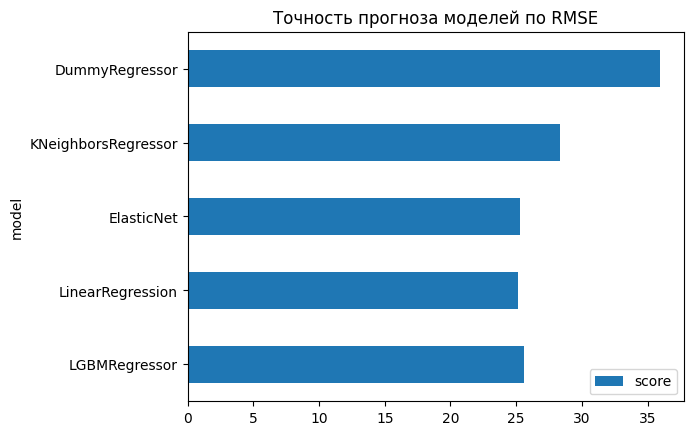

In [22]:
df_results.drop('params', axis=1).plot(kind='barh', title='Точность прогноза моделей по RMSE');

## Тестирование выбранной модели

In [23]:
# данные после кодирования и масштабирования
features_train_transformed = preprocessor.fit_transform(features_train, target_train)
features_test_transformed = preprocessor.transform(features_test)
# выбор лучшей модели
best_name = df_results.query('score == score.min()').index[0]
best_model = df_results.query('score == score.min()').params[0][1]
best_model.fit(features_train_transformed, target_train)
# результаты оценки модели тестовых данных
predictions = best_model.predict(features_test_transformed)                               
score = mean_squared_error(target_test, predictions) ** .5
print('Точность прогноза на тестовых данных для %s по RMSE равна %.3f' %(best_name, score)) 

Точность прогноза на тестовых данных для LinearRegression по RMSE равна 43.271


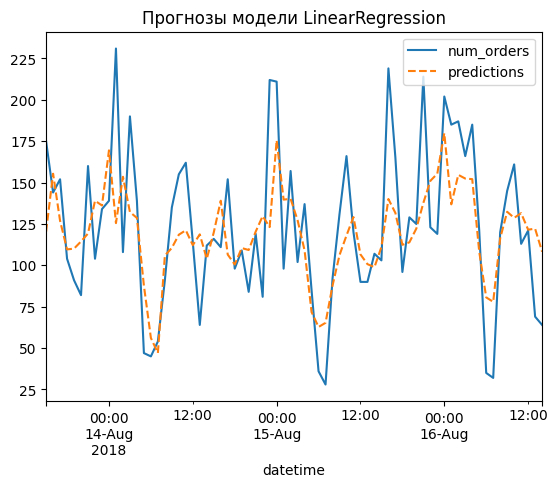

In [24]:
# график прогнозов модели
test = pd.DataFrame(target_test)
test['predictions'] = predictions
test[:72].plot(kind='line', title='Прогнозы модели %s' %best_name, style=['-', '--']);

## Общие выводы

Хотя темой данного проекта были временные ряды и для разработаны особые средства прогнозирования. Мы применили универсальный подход, характерный для задач регрессии. Спецификой работы стало создание большого количества искусственных признаков, таких как: 
признаки с временными лагами, с использованием скользящих окон, с указателями времени суток и дней недели, а также разностей временного ряда. Особо отслеживалась возможность утечки текущих данных в обучающие признаки.  
Было обучено несколько моделей разных типов на нескольких наборах гиперпараметров. Наибольшую точность показали модели _LGBMRegressor_ и _LinearRegression_, незначительно отличаясь друг от друга по точности. Обе модели достаточно хорошо улавливает циклические колебания, но первая резче реагирует на пиковые значения, вторая - немного сглаживает.  
Отобранная лучшая модель успешно преодолела требуемый порог точности _RMSE< 48_, хотя и показала значительно худшее качество, чем на валидации.